# Metrics

> Metric tracking and analysis tools

In [2]:
#| default_exp metrics

In [5]:
import os
print(os.getcwd())
os.chdir('/home/export/personal/sara/Documents/BIOMONAI/deepCLEM_bioMONAI')
print(os.getcwd())

/home/export/personal/sara/Documents/BIOMONAI/deepCLEM_bioMONAI/nbs
/home/export/personal/sara/Documents/BIOMONAI/deepCLEM_bioMONAI


In [6]:
#| hide
from nbdev.showdoc import *

In [24]:
#| export
import numpy as np
from numpy import trapz

from torch import abs, sqrt, div, complex64, where, isinf, zeros_like, real, isnan
from torch.fft import fftshift
from torch.fft import fft2

from fastai.vision.all import AvgMetric
from monai.losses import SSIMLoss
from monai.metrics import PSNRMetric as _PSNR, RMSEMetric as _RMSE, MSEMetric as _MSE, MAEMetric as _MAE, SSIMMetric as _SSIM

from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc

from bioMONAI.core import torch_from_numpy

In [25]:
#| export
def SSIMMetric(spatial_dims=3, **kwargs):
    def SSIM(x, y):
        return _SSIM(spatial_dims, **kwargs)(x,y).mean()
    return AvgMetric(SSIM)

def MSEMetric(**kwargs):
    def MSE(x, y):
        return _MSE(**kwargs)(x,y).mean()
    return AvgMetric(MSE)

def MAEMetric(**kwargs):
    def MAE(x, y):
        return _MAE(**kwargs)(x,y).mean()
    return AvgMetric(MAE)

def RMSEMetric(**kwargs):
    def RMSE(x, y):
        return _RMSE(**kwargs)(x,y).mean()
    return AvgMetric(RMSE)

def PSNRMetric(max_val, **kwargs):
    def PSNR(x, y):
        return _PSNR(max_val, **kwargs)(x,y).mean()
    return AvgMetric(PSNR)



### ROC Curve

In [33]:
def plot_roc_curve_with_std(y_probs_folds, y_true_folds, fold_legend_info = False):

    """
    Plot ROC curves with the standard deviation using the probabilities for each fold after applying crossvalidation.

    Parameters:
        y_probs_folds: List of arrays of the predicted probabilities (for the positive class) for each fold.
        y_true_folds: List of arrays of the true labels for each fold.

    """
    true_pos_rates = []
    areas_under_curve = []
    mean_false_pos_rate = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))

    # Loop to get the ROC curve of each fold
    for fold, (y_probs, y_true) in enumerate(zip(y_probs_folds, y_true_folds)):
        # Calculate the ROC curve for the fold
        calc_ROC = RocCurveDisplay.from_predictions(
            y_true,
            y_probs,
            name=f"ROC fold {fold + 1}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        
        if fold_legend_info == False or fold_legend_info == None:
            calc_ROC.line_.set_label('_nolegend_')
        elif fold_legend_info == True:
            pass

        # Interpolate TPR
        interp_tpr = np.interp(mean_false_pos_rate, calc_ROC.fpr, calc_ROC.tpr)
        interp_tpr[0] = 0.0
        true_pos_rates.append(interp_tpr)
        areas_under_curve.append(calc_ROC.roc_auc)


    # Compute mean and standard deviation of the AUC
    mean_tpr = np.mean(true_pos_rates, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_false_pos_rate, mean_tpr)
    std_auc = np.std(areas_under_curve)

    # Plot the mean ROC curve
    ax.plot(
        mean_false_pos_rate,
        mean_tpr,
        color="r",
        label=r"Mean ROC (AUC = %0.2f %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # Plot the standard deviation of the true positive rates
    std_tpr = np.std(true_pos_rates, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_false_pos_rate,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"1 std. dev.",
    )

    # Add labels and legend
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"ROC curve with standard deviation",
    )
    ax.legend(loc="lower right")
    plt.show()

##### Example: plot the ROC curve for the data after applying cross-validation and training in order to visualize the standard deviation to compare between splits.

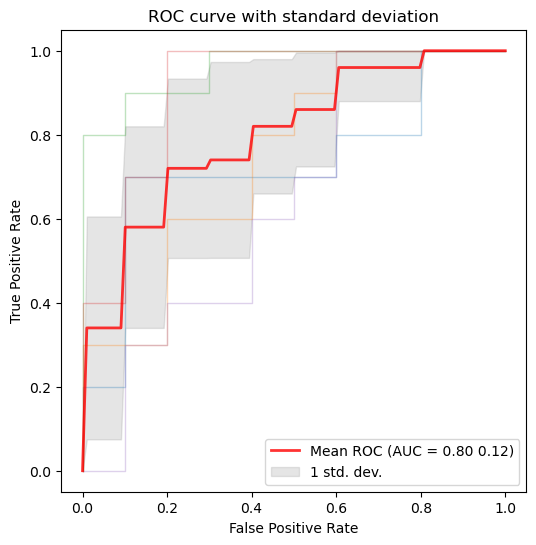

In [34]:
# For this example the iris dataset is used, but in order to apply it succesfully for binary classification,
# the dataset is reduced to two classes and the features are increased by adding noise.

# Step 1: Data loading and preprocessing
iris = load_iris()
target_names = iris.target_names
X, y = iris.data, iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Step 2: Adding noise to the data
random_state = np.random.RandomState(0)
X = np.concatenate([X, random_state.randn(n_samples, 300 * n_features)], axis=1)

# Step 3: Application of  cross-validation
cv = StratifiedKFold(n_splits=5)
splits = list(cv.split(X, y))

# Step 4: Training of a SVM algorithm
y_probs_folds = []
y_true_folds = []

classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)

# Obtaining the probabilities and true labels for each fold
for train_idx, test_idx in splits:
    # Train and predict
    classifier.fit(X[train_idx], y[train_idx])
    y_probs_folds.append(classifier.predict_proba(X[test_idx])[:, 1])  # Probabilities for the positive class
    y_true_folds.append(y[test_idx])  # True labels for the fold

# Call the function to plot the ROC curve with the standard deviation
plot_roc_curve_with_std(y_probs_folds, y_true_folds, fold_legend_info = False)

### Fourier Ring Correlation

#### Radial mask

In [ ]:
#| export

def radial_mask(r,      # Radius of the radial mask
                cx=128, # X coordinate mask center
                cy=128, # Y coordinate maske center
                sx=256, # Size of the x-axis
                sy=256, # Size of the y-axis
                delta=1,# Thickness adjustment for the circular mask
               ):

    """
    Generate a radial mask.

    Returns:
       - numpy.ndarray: Radial mask.
    """
    
    sx = np.arange(0, sx)
    sy = np.arange(0, sy)

    # Calculate squared distances from each point in the grid to the center
    ind = (sx[np.newaxis, :] - cx) ** 2 + (sy[:, np.newaxis] - cy) ** 2

    # Define inner boundary of the circular mask
    ind1 = ind <= ((r[0] + delta) ** 2)

    # Define outer boundary of the circular mask
    ind2 = ind > (r[0] ** 2)

    # Create the radial mask by combining inner and outer boundaries
    return ind1 * ind2


In [ ]:
#| export

def get_radial_masks(width, # Width of the image
                     height, # Height of the image
                     ):

    """
    Generates a set of radial masks and corresponding to spatial frequencies.

    Returns:
        tuple: A tuple containing:
            - numpy.ndarray: Array of radial masks.
            - numpy.ndarray: Array of spatial frequencies corresponding to the masks.
    """

    # Calculate Nyquist frequency
    freq_nyq = int(np.floor(int(min(width, height)) / 2.0))
   
    # Generate radii from 0 to Nyquist frequency
    radii = np.arange(freq_nyq).reshape(freq_nyq, 1)

    # Generate radial masks using the radial_mask function    
    radial_masks = np.apply_along_axis(radial_mask, 1, radii, width//2, height//2, width, height, 1)

    # Calculate spatial frequencies
    spatial_freq = radii.astype(np.float32) / freq_nyq
    spatial_freq = spatial_freq / max(spatial_freq)
    spatial_freq = spatial_freq.squeeze(1)

    return radial_masks, spatial_freq


#### Fourier ring correlation

In [ ]:
#| export
def get_fourier_ring_correlations(image1, # First input image
                                  image2, # Second input image
                                  ):
  
    """
    Compute Fourier Ring Correlation (FRC) between two images.

    Returns:
        tuple: A tuple containing:
            - torch.Tensor: Fourier Ring Correlation values.
            - torch.Tensor: Array of spatial frequencies.
    """
    

    # Get image height and width
    height = image1.shape[len(image1.shape)-1]
    width = image1.shape[len(image1.shape)-2]
    
    # Get set of radial masks, spatial frequency, and Nyquist frequency
    radial_masks, spatial_frequency = get_radial_masks(height,width)

    # Get Nyquist frequency
    freq_nyq = len(spatial_frequency)
    
    # Transform tensor to complex
    image1 = image1.to(complex64)
    image2 = image2.to(complex64)

    # Transofrm array dimensions to (freq_nyq, width. height)
    image1 = image1.unsqueeze(0).repeat(freq_nyq, 1, 1)
    image2 = image2.unsqueeze(0).repeat(freq_nyq, 1, 1)

    # Convert spatial frequency and radial masks to torch.tensor
    spatial_frequency = torch_from_numpy(spatial_frequency)
    radial_masks = torch_from_numpy(radial_masks)

    # Transform tensor to complex
    radial_masks = radial_masks.to(complex64)
         
    # Compute fourier transform
    fft_image1 = fftshift(fft2(image1))
    fft_image2 = fftshift(fft2(image2))

    # Get elements only in the ring
    t1 = fft_image1 * radial_masks
    t2 = fft_image2 * radial_masks
        
    # image2 to complex conjugate
    t2_conj = t2.conj()

    # Numerator
    numerator = abs(real((t1 * t2_conj).sum(dim=(1,2))))

    # Denominator    
    denominator_1 = ((abs(t1) * abs(t1)).sum(dim=(1,2)))
    denominator_2 = ((abs(t2) * abs(t2)).sum(dim=(1,2)))     
    denominator = sqrt(denominator_1 * denominator_2)
   
    # Fourier shell correlation
    FRC = div(numerator, denominator)

    # Remove possible inf and NaN.
    FRC = where(isinf(FRC), zeros_like(FRC), FRC)  # inf
    FRC = where(isnan(FRC), zeros_like(FRC), FRC)  # NaN

    return FRC , spatial_frequency

In [ ]:
#| export

def FRCMetric(image1, # First input image
              image2, # Second input image
              ):


    """
    Compute the area under the Fourier Ring Correlation (FRC) curve between two images.

    Returns:
        - float: The area under the FRC curve.
    """

    # Calculate the Fourier Ring Correlation and spatial frequency
    FRC, spatial_frequency = get_fourier_ring_correlations(image1, image2)

    # Convert to numpy
    FRC = FRC.numpy()
    spatial_frequency = spatial_frequency.numpy()
      
    # Compute the area under the curve using trapezoidal integration
    area = trapz(FRC, spatial_frequency)
    
    return area


---

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()